In [270]:
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx


In [272]:
def greedy_approach(k, D, order=2):
    # Get the number of nodes, square the distance matrix, and sum across the columns
    n = D.shape[0]
    D_squared = D ** order
    node_values = np.sum(D_squared, axis=0)
    D_copy = D.copy()

    # make the diagonal of the distance matrix infinite and make a visited array
    np.fill_diagonal(D_copy, np.inf)
    visited = np.zeros(n)

    # Initialize the matrix and loop through the number of edges 'k' we will be adding to each node
    matrix = np.zeros((n, n))
    for iteration in range(k):
        current_vals = node_values.copy()
        node_mask = (visited <= iteration)

        # For every edge iteration, choose the most isolated node and find its closest neighbor
        while np.sum(visited) < (iteration+1)*n:
            i = np.argmax(current_vals * node_mask)
            j = np.argmin(D_copy[:,i] / node_mask)

            # Mark the nodes as visited and update the matrix
            visited[i] += 1
            visited[j] += 1
            node_mask[i], node_mask[j] = False, False
            matrix[i, j], matrix[j, i] = 1, 1

            # subtract the distance between i and j from the node values for the next iteration
            node_values[i] -= D_squared[i, j]
            node_values[j] -= D_squared[i, j]

            # Make it so that the edges cannot be chosen again
            D_copy[i, j], D_copy[j, i] = np.inf, np.inf

    # Return the matrix
    return matrix


def find_near_solution(adj_matrix, D, nearest = 5):
    matrix = adj_matrix.copy()
    n = matrix.shape[0]
    # Choose a random column/node
    j1 = np.random.choice(n)

    # find a node that is connected to j1
    i_one_j1 = np.random.choice(np.where(matrix[:,j1]==1)[0])

    # Find the zero candidates and remove the diagonal element
    zero_candidates = np.where(matrix[:,j1]==0)[0]
    zero_candidates = zero_candidates[zero_candidates != j1]

    # Limit the number of candidates to the nearest nodes
    close_nots = np.argpartition(D[zero_candidates,j1], nearest)[:nearest]
    i_not_j1 = np.random.choice(zero_candidates[close_nots])

    # find a correct j2 which is not connected to i_one_j1
    while True:
        j2 = np.random.choice(np.where(matrix[i_not_j1]==1)[0])
        if (matrix[i_one_j1,j2]) == 0 and (j2 != j1) and (i_one_j1 != j2):
            break

    # swap the two nodes that are connected to j1
    matrix[i_one_j1,j1] = 0
    matrix[j1,i_one_j1] = 0
    matrix[i_not_j1,j1] = 1
    matrix[j1,i_not_j1] = 1    

    # # swap the two nodes that are connected to j2
    matrix[i_not_j1,j2] = 0
    matrix[j2,i_not_j1] = 0
    matrix[i_one_j1,j2] = 1
    matrix[j2,i_one_j1] = 1
        
    # Return the near solution
    return matrix


def annealing(adj_mat, D, batch_size = 5, num_nearest=5, maxiter = 100, temp = 1000, alpha = 0.99):
    # Initialize the loss list, the current adjacency matrix, and append the current loss
    loss_list = []
    current = adj_mat.copy()
    loss_current = np.sum(D * current)
    loss_list.append(loss_current)
    accept_list = []

    # Loop through the maximum number of iterations
    for _ in range(maxiter):
        temp = max(alpha*temp,10e-20)

        # copy and get the current candidate and loop through the batch size
        candidate = current.copy()
        for _ in range(batch_size):
            candidate = find_near_solution(candidate, D, nearest=num_nearest)

        # get the loss of the candidate and check if it is better than the current loss
        loss_candidate = np.sum(D * candidate)
        if loss_candidate < loss_current:
            current = candidate
            loss_current = loss_candidate

        # Otherwise, accept the candidate with a certain probability
        else:
            prob = np.exp(np.max([-(loss_candidate - loss_current) / temp,-50]))
            accept_list.append(prob)
            if np.random.rand() < prob:
                current = candidate
                loss_current = loss_candidate

        # Append the loss to the loss list
        loss_list.append(loss_current)

    # Return the adjacency matrix and the loss list
    return current, loss_list, accept_list


def get_adjacency_matrix(data, k, metric, num_nearest=5, maxiter=10000, temp=10, alpha=0.8, show_loss=False):
    # Get the distance matrix according to the matric and run the greedy approach and the annealing algorithm
    D = np.apply_along_axis(metric, 2, data[:,np.newaxis,:] - data[np.newaxis,:,:])
    matrix = greedy_approach(k, D, order=1)
    matrix, loss_list, accept_list = annealing(matrix, D, batch_size=1, num_nearest=num_nearest, maxiter=maxiter, temp=temp, alpha=alpha)

    # Plot the loss list if required
    if show_loss:
        plt.title("Loss over iterations")
        plt.plot(loss_list)
        plt.show()

    # Return the adjacency matrix
    return matrix


/var/folders/t4/43zvz_r119l5fk_hdwn6_mbw0000gn/T/ipykernel_86819/1404051406.py:16: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  points = np.random.multivariate_normal(mean, cov, n)


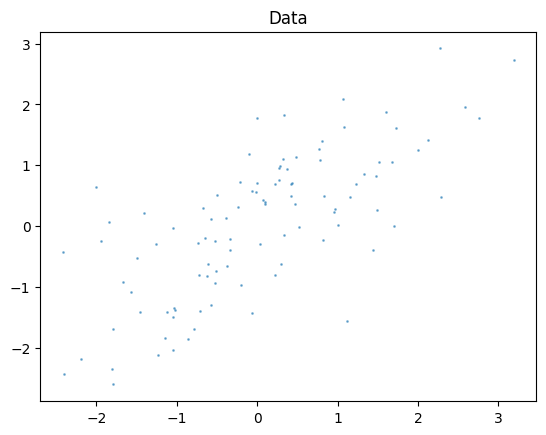

/var/folders/t4/43zvz_r119l5fk_hdwn6_mbw0000gn/T/ipykernel_86819/1699015893.py:21: RuntimeWarning: divide by zero encountered in divide
  j = np.argmin(D_copy[:,i] / node_mask)


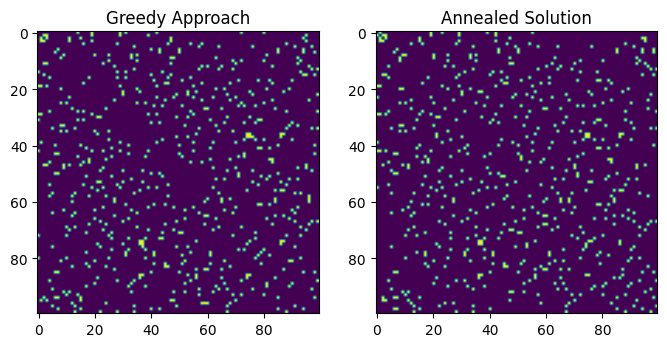

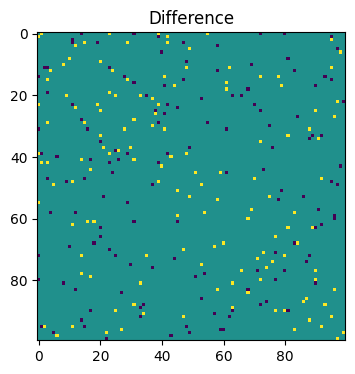

Greedy Approach 329.18419693864655
Annealed Solution 294.4643592130972
Percent Improvement: 0.10547237093529256


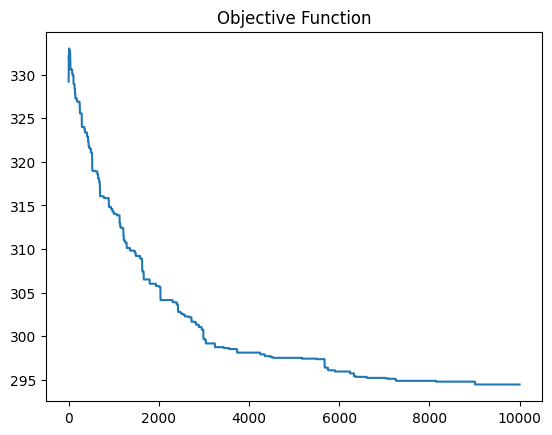

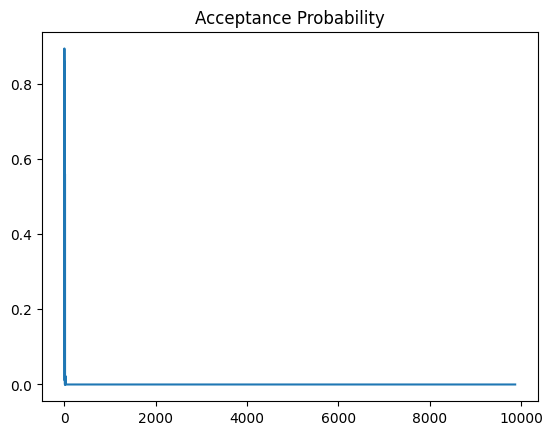

294.4643592130972


In [277]:
# main parameters
n = 100
k = 6
exponent = 1
batch_size = 1
num_nearest = 5
maxiter = 10000
temp = 10
alpha = 0.8

# Data parameters
cov = np.array([[1, 1.5], [1.5, 1]])
mean = np.array([0, 0])

# Generate the data and plot it
points = np.random.multivariate_normal(mean, cov, n)
plt.title("Data")
plt.scatter(points[:,0], points[:,1], s=1, alpha=0.5)
plt.show()

# Run the greedy approach
D = np.linalg.norm(points[:,np.newaxis,:] - points[np.newaxis,:,:], axis=2, ord=2)
matrix = greedy_approach(k, D, order=exponent)

# Get the annealed solution
annealed, loss, prob_list = annealing(matrix, D, batch_size=batch_size, num_nearest=num_nearest, maxiter=maxiter, temp=temp, alpha=alpha)

# Plot the matrix
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Greedy Approach")
plt.imshow(matrix)

# Plot the annealed matrix
plt.subplot(1,2,2)
plt.title("Annealed Solution")
plt.imshow(annealed)
plt.show()

# Plot the difference between the two matrices
plt.figure(figsize=(4,4))
plt.title("Difference")
plt.imshow(annealed - matrix)
plt.show()

print("Greedy Approach {}".format(np.sum(matrix * D)))
print("Annealed Solution {}".format(np.sum(annealed * D)))
print("Percent Improvement: {}".format((np.sum(matrix * D) - np.sum(annealed * D)) / np.sum(matrix * D)))

# Plot the objective function
plt.title("Objective Function")
plt.plot(loss)
plt.show()

# Plot the acceptance probability
plt.title("Acceptance Probability")
plt.plot(prob_list)
plt.show()

print(np.sum(annealed * D))

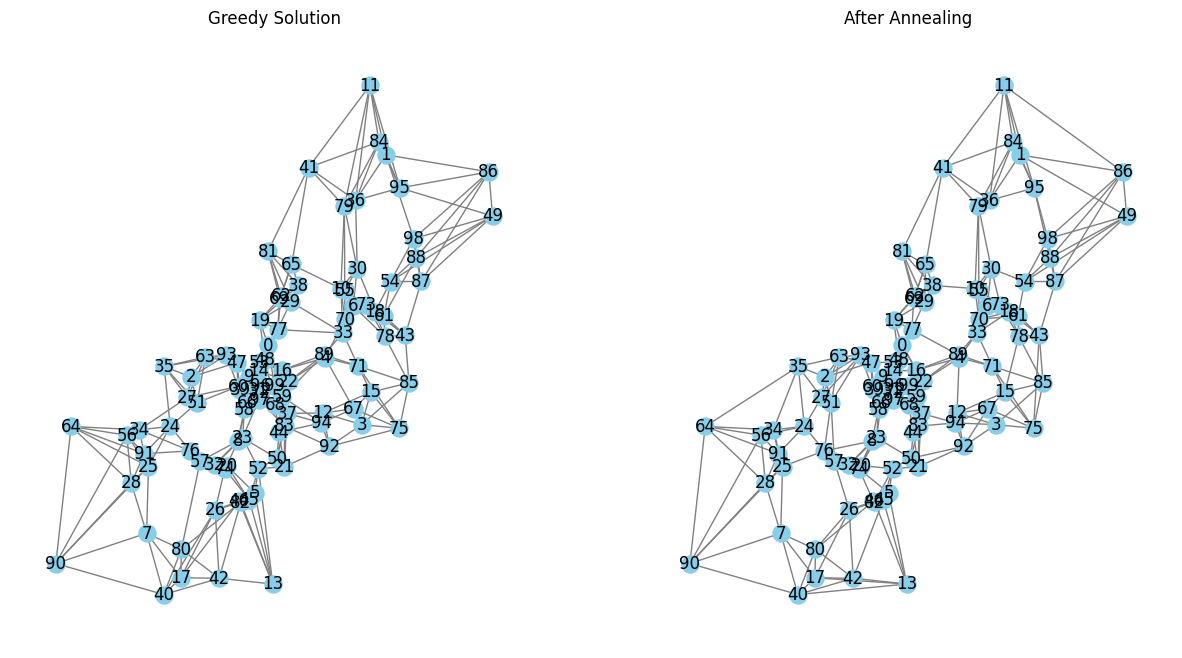

In [274]:
# Add nodes with positions
G = nx.Graph()
for i in range(n):
    G.add_node(i, pos=points[i])

# Add edges from the adjacency matrix
for i in range(n):
    for j in range(i + 1, n):
        if matrix[i, j] > 0:
            G.add_edge(i, j)

# Get positions of nodes
pos = {i: points[i] for i in range(n)}

# Add nodes with positions
G2 = nx.Graph()
for i in range(n):
    G2.add_node(i, pos=points[i])

# Add edges from the adjacency matrix
for i in range(n):
    for j in range(i + 1, n):
        if annealed[i, j] > 0:
            G2.add_edge(i, j)

# Get positions of nodes
pos = {i: points[i] for i in range(n)}


# Draw the graph
plt.figure(figsize=(15, 8))
plt.subplot(121)
nx.draw(G, pos, with_labels=True, node_size=150, node_color='skyblue', edge_color='gray')
plt.title('Greedy Solution')
plt.subplot(122)
nx.draw(G2, pos, with_labels=True, node_size=150, node_color='skyblue', edge_color='gray')
plt.title('After Annealing')
plt.show()

In [279]:
# check how connected the graphs are
def check_connectivity(G,name):
    print("{}:".format(name))
    print("Diameter: {}".format(nx.diameter(G)))
    print("Average shortest path: {}".format(nx.average_shortest_path_length(G)))
    print("Algebraic connectivity: {}".format(nx.algebraic_connectivity(G)))
    print()

check_connectivity(G,"Greedy Solution")
check_connectivity(G2,"Annealed Solution")

Greedy Solution:
Diameter: 13
Average shortest path: 5.01959595959596
Algebraic connectivity: 0.08863990794256617

Annealed Solution:
Diameter: 12
Average shortest path: 5.132121212121212
Algebraic connectivity: 0.08954653029664618

